In [1]:
import pandas as pd
import numpy as np
import ot
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sn
from pathlib import Path
from sklearn.utils import check_random_state
from scipy.spatial.distance import cdist
# User functions
from utils import BaseTransport, calc_parsimony

In [2]:
# Experiment hyperparamters
rng = np.random.RandomState(42)

In [3]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:  # saves all figures in a figure directory in the local directory
    figure_dir = Path('.') / 'figures' / 'adult-income-experiment'
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

## Loading and Preprocessing the data


In [5]:
from data_utils import load_and_preprocess_nba_data
continuous_variables_indicies = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# n_samples = 'balanced'
# n_samples = 1000
X, Y, feature_names = load_and_preprocess_nba_data(rng, return_column_names=True)
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
print(X)
print(Y)
parameters = pd.read_csv('./Source_Target/experiment_parameters.csv')
split_on = parameters['split_feature'].values[0]
instance_1 = parameters['instance_1'].values[0]
instance_2 = parameters['instance_2'].values[0]


Splitting on TEAM with LAL and HOU resulting source shape: (36, 20), target shape: (36, 20).
###############################
['Games Played', 'MIN', 'Points', 'Field Goals Made', 'Field Goals Attempted', 'Field Goal Percentage', 'Three-Point Field Goals Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'Offensive Rebounds', 'Defensive Rebounds', 'Rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers', 'Efficiency']
###############################
######################## Source_Data_A Dropped ##########################
    Games Played   MIN  Points  Field Goals Made  Field Goals Attempted  \
3              5  37.0    14.2               5.6                   14.6   
34            21  18.4     5.9               2.1                    4.7   
32            21  25.0     8.0               2.8                    8.1   
19             5  28.8    17.4               5.0                   12.4   
17            12  10.3     1.8               0.8                    2.3   
5              5  22.2     7.4    

## Performing Clustering

In [6]:
def get_mixed_variable_desiderata(X_continuous, Y_continuous, Z, standardizer, continuous_variables_indicies,
                                  n_expectation=10, inter=None, rng=None):
    rng = check_random_state(rng)
    non_continuous_variables_indicies = np.delete(np.arange(X.shape[1]), continuous_variables_indicies)
    fids = np.zeros(n_expectation)
    pars = np.zeros(n_expectation)
    for loop_idx in range(n_expectation):
        # since Z is in a pseudo continuous space, we project it to a discrete space using the phase change graph defined within Z
        # since the Z[i, j_descrete] is probability of that point being positive
        Z_projected_discrete = Z.copy()
        uniform_vars = rng.uniform(size=(Z.shape[0], len(non_continuous_variables_indicies)))
        positive_probability = Z[:, non_continuous_variables_indicies]
        Z_projected_discrete[:, non_continuous_variables_indicies] = (uniform_vars <= positive_probability).astype(Z.dtype)
        Z_projected_continous = standardizer.transform(Z_projected_discrete)
        # Calculating fidelity
        M = cdist(Y_continuous, Z_projected_continous, 'sqeuclidean')
        a,b = ot.utils.unif(X.shape[0]), ot.utils.unif(Z.shape[0])
        fid = ot.emd2(a, b, M)
        # Calculating parsimony
        par = calc_parsimony(X_continuous, Z_projected_continous)
        # recording
        fids[loop_idx] = fid
        pars[loop_idx] = par
    fid, par = fids.mean(), pars.mean()
    if inter is not None:
        print(f'Fid: {fid:.3f}, Par: {par:.3f}, Inter: {inter}')
    return fid, par, inter

In [7]:
def mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_vars):
    non_continuous_vars = np.delete(np.arange(X_cluster.shape[1]), continuous_variables_indicies)
    X_cluster_pushed = X_cluster.copy()
    X_cluster_means = X_cluster.mean(axis=0)
    Z_cluster_means = Z_cluster.mean(axis=0)
    X_cluster_pushed[:, continuous_vars] += Z_cluster_means[continuous_vars] - X_cluster_means[continuous_vars]
    X_cluster_pushed[:, non_continuous_vars] = Z_cluster_means[non_continuous_vars]  # sets T(X_discrete) to Pr(Z_discrete = 1)
    return X_cluster_pushed

In [8]:
## Hyperparameters
max_clusters = 10

In [9]:
# Increasing the number of clusters to see the increase in fidelity and decrease in interpretability

cluster_histories = []

# fitting standardizer on our source domain
standardizer = standardizer.fit(X)

# Finding base desiderata values for T=id
X_continuous, Y_continuous = standardizer.transform(X), standardizer.transform(Y)
fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, X, standardizer, continuous_variables_indicies,
                                                n_expectation=1, inter=0, rng=rng)  # showing the base desiderata
fids = np.zeros(max_clusters+1)
fids[0] = fid
pars = np.zeros(max_clusters+1)
pars[0] = par
inters = np.zeros(max_clusters+1)
inters[0] = 0

################################################################################################################################################
T = BaseTransport(X, Y, fit=True)
Z = T.forward(X, Y)
Z_continuous = standardizer.transform(Z)

for n_clusters in range(1, max_clusters+1):
     # performs paired clustering in a continuous joint X,Z space
    cluster_labels = T._pair_clustering(X_continuous, Z=Z_continuous, n_clusters=n_clusters, rng=rng) 
    
    Z_clusters = np.zeros_like(Z)  # the final output of the cluster mean shift transport
    for cluster_idx in range(n_clusters):
        X_cluster = X[cluster_labels == cluster_idx]
        Z_cluster = Z[cluster_labels == cluster_idx]
        # A method similar for cluster mean shift transport, but with accounting for binary variables
        X_cluster_pushed = mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_variables_indicies)
        Z_clusters[cluster_labels == cluster_idx] = X_cluster_pushed
        
    # getting desiderata information
    fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, Z_clusters, standardizer, 
                                                    continuous_variables_indicies, n_expectation=30,
                                                    inter=n_clusters, rng=rng)
    fids[n_clusters] = fid
    pars[n_clusters] = par
    inters[n_clusters] = n_clusters

    cluster_record = {
        'labels': cluster_labels.copy(),
        'Z_clusters': Z_clusters.copy(),
        'n_clusters': n_clusters
    }
    cluster_histories.append(cluster_record)

Fid: 25.612, Par: 521.878, Inter: 0
Fid: 24.886, Par: 547.981, Inter: 1
Fid: 24.143, Par: 574.836, Inter: 2
Fid: 23.008, Par: 619.034, Inter: 3
Fid: 22.615, Par: 633.867, Inter: 4
Fid: 22.210, Par: 813.993, Inter: 5
Fid: 20.705, Par: 890.229, Inter: 6
Fid: 21.142, Par: 856.250, Inter: 7
Fid: 20.455, Par: 913.908, Inter: 8
Fid: 20.864, Par: 942.255, Inter: 9
Fid: 19.667, Par: 982.777, Inter: 10


In [10]:
# changing fidelity to be % of shift explained
def calc_percent_explained(x):
    return 100*(max_fid - x) / max_fid
max_fid = fids[0]
percent_explained = np.apply_along_axis(calc_percent_explained, 0, fids)

Results with splitting on TEAM:


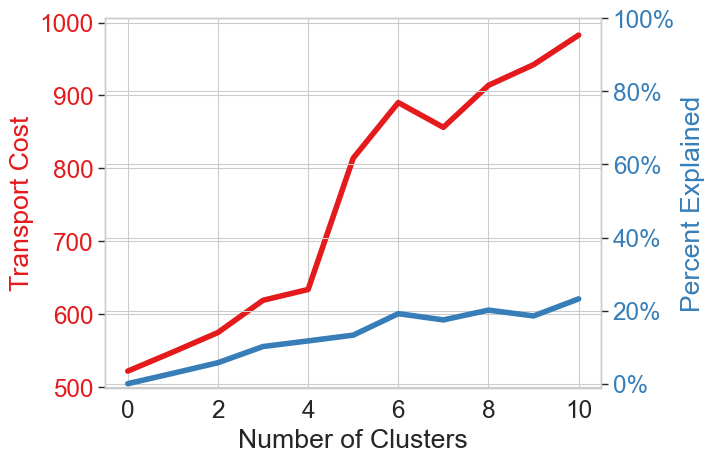

In [14]:
# Create Plot
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Number of Clusters') 
ax1.set_ylabel('Transport Cost', color = pal[0]) 
ax1.plot(np.arange(max_clusters+1), pars, color = pal[0],
         **{k:v for (k,v) in line_parms.items() if k != 'color'})  
ax1.tick_params(axis ='y', labelcolor = pal[0]) 
# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('Percent Explained', color = pal[1]) 
ax2.plot(np.arange(max_clusters+1), percent_explained, color = pal[1],
         **{k:v for (k,v) in line_parms.items() if k != 'color'}) 
ax2.tick_params(axis ='y', labelcolor = pal[1]) 
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylim(None, 100)


print(f'Results with splitting on {split_on}:')
if save_figures: plt.savefig(
    figure_dir / f'logitics_data_on{split_on}--clustering-results.{save_parms["format"]}',
    **save_parms
    )
plt.show()

In [15]:
for record_idx in range(max_clusters):
    cluster_record = cluster_histories[record_idx]
    Z_clusters = cluster_record['Z_clusters']
    labels = cluster_record['labels']
    n_clusters = cluster_record['n_clusters']
    print(f'Starting {n_clusters} cluster results:')

    tgt = f'{instance_2}'
    src = f'{instance_1}'
    with np.printoptions(precision=3, suppress=True):
        for cluster_idx in range(n_clusters):
            print(f'\tCluster: {cluster_idx}')
            print(f'\t\t         Names={[name[:3] for name in feature_names]}')
            print(f'\t\t   {src}_mean={X[cluster_idx==labels].mean(axis=0)}')
            print(f'\t\tT({tgt})_mean={Z_clusters[cluster_idx==labels].mean(axis=0)}')
        print()    

Starting 1 cluster results:
	Cluster: 0
		         Names=['Gam', 'MIN', 'Poi', 'Fie', 'Fie', 'Fie', 'Thr', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'Off', 'Def', 'Reb', 'Ass', 'Ste', 'Blo', 'Tur', 'Eff']
		   HOU_mean=[11.417 25.958 11.669  4.294  9.119 43.739  1.119  3.414 29.956  1.975
  2.522 71.981  0.997  3.692  4.675  2.631  0.753  0.539  1.344 13.55 ]
		T(LAL)_mean=[11.528 27.6   12.111  4.236  9.658 43.447  1.425  4.15  27.519  2.228
  3.094 66.583  1.228  3.981  5.2    2.25   0.892  0.611  1.569 13.203]

Starting 2 cluster results:
	Cluster: 0
		         Names=['Gam', 'MIN', 'Poi', 'Fie', 'Fie', 'Fie', 'Thr', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'Off', 'Def', 'Reb', 'Ass', 'Ste', 'Blo', 'Tur', 'Eff']
		   HOU_mean=[11.6   21.136  6.94   2.516  5.984 40.784  0.92   2.836 29.848  1.
  1.312 69.876  0.764  2.32   3.064  1.5    0.58   0.296  0.868  7.74 ]
		T(LAL)_mean=[11.12  24.392  8.656  3.12   7.5   41.108  1.312  3.712 30.372  1.112
  1.58  64.184  0.94   3.168  4.1    1.312  0.62  

In [16]:
# ergonomic blank space : ) 






























































